# Test and Trial on Gaussian Mixture Distribution.

## Functions

In [11]:
%matplotlib inline

import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.distributions import (
    Categorical, NormalWithSoftplusScale, Mixture)

from nn4post import InferenceBuilder
try:
    from tensorflow.contrib.distributions import Independent
except:
    print('WARNING - Your TF < 1.4.0.')
    from nn4post.utils.independent import Independent

In [2]:
# For testing (and debugging)
SEED = 123456
tf.set_random_seed(SEED)
np.random.seed(SEED)

In [3]:
def make_log_posterior(target_c, target_mu, target_zeta):
  
    target_c = tf.convert_to_tensor(target_c)
    target_mu = tf.convert_to_tensor(target_mu)
    target_zeta = tf.convert_to_tensor(target_zeta)

    # -- Gaussian Mixture Distribution
    with tf.name_scope('posterior'):

      cat = Categorical(probs=target_c)
      components = [
          Independent(
              NormalWithSoftplusScale(target_mu[i], target_zeta[i])
          ) for i in range(target_c.shape[0])
      ]
      p = Mixture(cat, components)

      def log_posterior(theta):
          return p.log_prob(theta)

    return log_posterior

In [4]:
def shall_stop(loss_values, tolerance, n_means=20):

    if len(loss_values) < 2 * n_means:

        return False

    else:
        previous_loss = np.mean(loss_values[-2*n_means:-n_means])
        current_loss = np.mean(loss_values[-n_means:])
        delta_loss = previous_loss - current_loss
        relative_delta_loss = abs( delta_loss / (current_loss + 1e-8) )

        if relative_delta_loss < tolerance:
            return True
        else:
            return False


def test(target_c, target_mu, target_zeta,
         init_var, tolerance=1e-2):
    """Test on Gaussian mixture distribution as the target.
    
    Args:
        target_c: Numpy array.
        target_mu: Numpy array.
        target_zeta: Numpy array.
        init_var: Dictionary with keys: "a", "mu", and "zeta" and
            values numpy arraies.
    
    Returns:
        Dictionary with keys: "loss", "a", "mu", and "zeta", and
        values the values at each iteration, collected in a list.
    """

    tf.reset_default_graph()

    log_p = make_log_posterior(target_c, target_mu, target_zeta)

    n_c, n_d = init_var['mu'].shape
    ib = InferenceBuilder(n_c, n_d, log_p)
    
    a = tf.Variable(init_var['a'], dtype='float32')
    mu = tf.Variable(init_var['mu'], dtype='float32')
    zeta = tf.Variable(init_var['zeta'], dtype='float32')
    loss, gradients = ib.make_loss_and_gradients(a, mu, zeta)

    optimizer = tf.train.RMSPropOptimizer(0.01)
    train_op = optimizer.apply_gradients(gradients)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)

        test_result = {'loss': [], 'a': [], 'mu': [], 'zeta': []}
        step = 0

        while not shall_stop(test_result['loss'], tolerance):

            _, loss_val, a_val, mu_val, zeta_val \
                = sess.run([train_op, loss, a, mu, zeta])

            test_result['loss'].append(loss_val)
            test_result['a'].append(a_val)
            test_result['mu'].append(mu_val)
            test_result['zeta'].append(zeta_val)
            
            step += 1
            if (step+1) % 100 == 0:
                print(step, loss_val)

    return test_result

In [5]:
# Helpers

def softplus(x, limit=10.):
    return np.where(x<limit, np.log(1. + np.exp(x)), x)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

## Trials

In [24]:
%%time

n_d = 2
ones = np.ones([n_d]).astype('float32')
target_c = np.array([0.7, 0.25, 0.05]).astype('float32')
target_mu = np.array([-3*ones, 0*ones, 3*ones]).astype('float32')
target_zeta = np.array([ones, ones, ones]).astype('float32')

n_c = 7
init_var = {
    'a': np.zeros([n_c]).astype('float32'),
    'mu': np.random.normal(0., 5., size=[n_c, n_d]).astype('float32'),
    'zeta': np.zeros([n_c, n_d]).astype('float32'),
}

init_var['mu'][0] = -3 * np.ones([n_d]).astype('float32')

test_result = test(target_c, target_mu, target_zeta,
                   init_var, tolerance=1e-2)

99 1.5822797
199 0.22937012
299 0.023991108
399 0.0083527565
CPU times: user 16min 23s, sys: 2min 49s, total: 19min 12s
Wall time: 6min


In [25]:
print(test_result['loss'][-30:])

[0.0035543442, 0.0037529469, 0.006169796, 0.0061826706, -0.0009059906, 0.0002193451, -0.00030255318, 0.0030059814, 0.0056848526, 0.0018715858, 0.0058717728, 0.0026419163, 0.0042686462, 0.006784439, 0.0029416084, 0.0019750595, 0.0051674843, 0.005097389, 0.0072636604, 0.0018596649, 0.0058283806, -0.0003247261, 0.0043201447, 0.005437851, 0.00029087067, 0.003014803, -0.00014400482, 0.00017476082, 0.0042910576, 0.0040254593]


In [26]:
print(softmax(test_result['a'][-1]), '\n')
print(test_result['mu'][-1], '\n')
print(test_result['zeta'][-1], '\n')

[3.0421141e-01 1.8687136e-03 2.2468475e-01 1.0488272e-01 3.1454128e-01
 4.9607143e-02 2.0400445e-04] 

[[-3.7187452  -3.0358307 ]
 [-4.742426   -0.7435574 ]
 [ 0.20906734  0.05482026]
 [-1.6628476  -1.805377  ]
 [-2.4731984  -3.150506  ]
 [ 3.0217924   3.0015004 ]
 [-1.44951     8.226146  ]] 

[[0.72825277 0.9792911 ]
 [0.94646454 0.06227794]
 [0.91713536 1.0102228 ]
 [1.0745777  1.3464437 ]
 [0.669621   0.89352196]
 [0.9830305  1.0011646 ]
 [1.0777491  0.87177366]] 



In [27]:
def plot_trajectory(trajectory):
    """Plot 2D trajectory.
    
    Args:
        trajectory: List of 2D numpy array.
    """
    n_points = len(trajectory)
    x = [_[0] for _ in trajectory]
    y = [_[1] for _ in trajectory]
    delta_x = [x[i+1] - x[i] for i in range(n_points-1)]
    delta_y = [y[i+1] - y[i] for i in range(n_points-1)]
    plt.quiver(x, y, delta_x, delta_y)

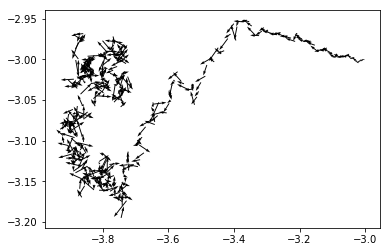

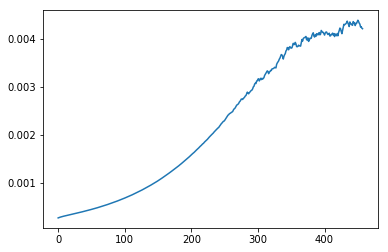

--------------


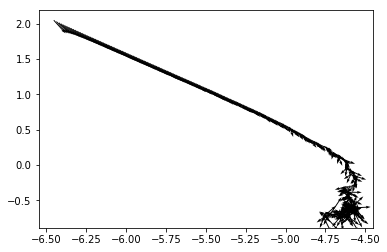

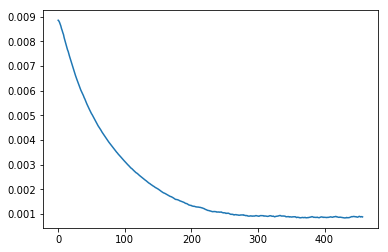

--------------


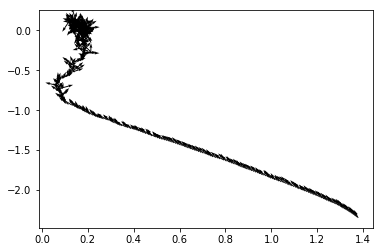

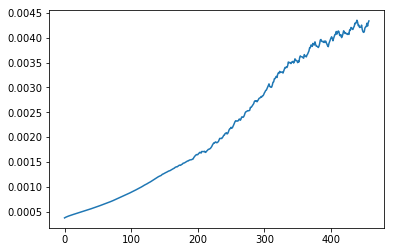

--------------


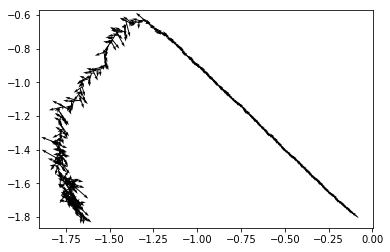

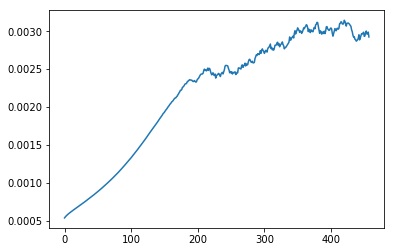

--------------


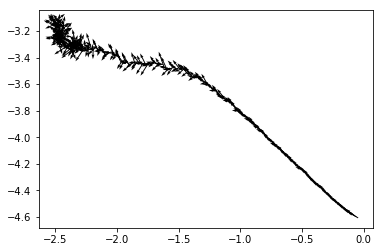

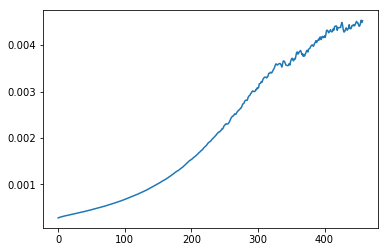

--------------


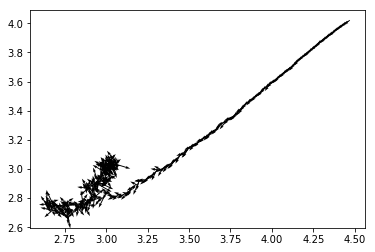

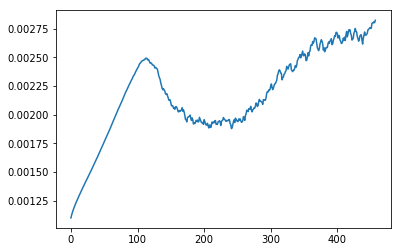

--------------


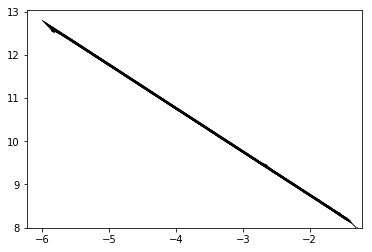

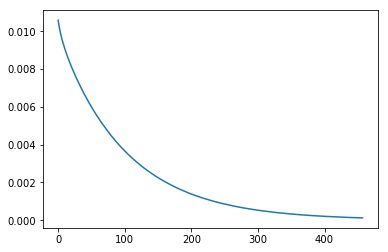

--------------


In [28]:
for i in range(n_c):
    
    plot_trajectory([_[i,:] for _ in test_result['mu']])
    plt.show()
    
    plt.plot([_[i] for _ in softmax(test_result['a'])])
    plt.show()
    
    print('--------------')